# Upload dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from google.colab import files
!pip install -q kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phamngocquy2004","key":"df7d4cd8de55c9dbdb448b7e668f888a"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d izzulhaqmahardika/coco-vehicles-car-bus-truck-motorcycle


Dataset URL: https://www.kaggle.com/datasets/izzulhaqmahardika/coco-vehicles-car-bus-truck-motorcycle
License(s): unknown
100% 3.16G/3.17G [00:35<00:00, 37.8MB/s]
100% 3.17G/3.17G [00:35<00:00, 94.8MB/s]


In [5]:
!unzip coco-vehicles-car-bus-truck-motorcycle.zip -d coco_vehicles



Streaming output truncated to the last 5000 lines.
  inflating: coco_vehicles/train2017_vehicles/000000443519.jpg  
  inflating: coco_vehicles/train2017_vehicles/000000443525.jpg  
  inflating: coco_vehicles/train2017_vehicles/000000443527.jpg  
  inflating: coco_vehicles/train2017_vehicles/000000443556.jpg  
  inflating: coco_vehicles/train2017_vehicles/000000443589.jpg  
  inflating: coco_vehicles/train2017_vehicles/000000443592.jpg  
  inflating: coco_vehicles/train2017_vehicles/000000443599.jpg  
  inflating: coco_vehicles/train2017_vehicles/000000443604.jpg  
  inflating: coco_vehicles/train2017_vehicles/000000443641.jpg  
  inflating: coco_vehicles/train2017_vehicles/000000443650.jpg  
  inflating: coco_vehicles/train2017_vehicles/000000443653.jpg  
  inflating: coco_vehicles/train2017_vehicles/000000443667.jpg  
  inflating: coco_vehicles/train2017_vehicles/000000443671.jpg  
  inflating: coco_vehicles/train2017_vehicles/000000443713.jpg  
  inflating: coco_vehicles/train2017_ve

In [6]:
import os
os.listdir('coco_vehicles/')


['instances_train2017_vehicles.json',
 'instances_val2017_vehicles.json',
 'val2017_vehicles',
 'train2017_vehicles',
 'dataset-metadata.json']

# convert sang
dataset/
├─ images/
│  ├─ train/
│  ├─ val/
├─ labels/
│  ├─ train/
│  ├─ val/

In [7]:
import json
import os
from shutil import copyfile

def convert_coco_to_yolo(coco_json_path, images_src_dir, images_dst_dir, labels_dst_dir):
    with open(coco_json_path) as f:
        data = json.load(f)

    os.makedirs(images_dst_dir, exist_ok=True)
    os.makedirs(labels_dst_dir, exist_ok=True)

    # Mapping image id → filename
    img_id_to_name = {img['id']: img['file_name'] for img in data['images']}

    # Mapping category id → class id (0-based)
    categories = {cat['id']: i for i, cat in enumerate(data['categories'])}

    annotations_per_img = {}
    for ann in data['annotations']:
        img_id = ann['image_id']
        if img_id not in annotations_per_img:
            annotations_per_img[img_id] = []
        annotations_per_img[img_id].append(ann)

    for img_id, anns in annotations_per_img.items():
        filename = img_id_to_name[img_id]
        copyfile(os.path.join(images_src_dir, filename), os.path.join(images_dst_dir, filename))

        # create label txt
        h, w = None, None
        # get image size
        from PIL import Image
        im = Image.open(os.path.join(images_src_dir, filename))
        w, h = im.size

        txt_file = os.path.join(labels_dst_dir, filename.replace('.jpg', '.txt'))
        with open(txt_file, 'w') as f:
            for ann in anns:
                cat_id = ann['category_id']
                class_id = categories[cat_id]
                bbox = ann['bbox']  # [x_min, y_min, width, height] in pixels
                x_center = (bbox[0] + bbox[2]/2)/w
                y_center = (bbox[1] + bbox[3]/2)/h
                width = bbox[2]/w
                height = bbox[3]/h
                f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

# Convert train
convert_coco_to_yolo('coco_vehicles/instances_train2017_vehicles.json',
                     'coco_vehicles/train2017_vehicles',
                     'dataset/images/train',
                     'dataset/labels/train')

convert_coco_to_yolo('coco_vehicles/instances_val2017_vehicles.json',
                     'coco_vehicles/val2017_vehicles',
                     'dataset/images/val',
                     'dataset/labels/val')

In [8]:
!ls

coco_vehicles				    dataset  kaggle.json
coco-vehicles-car-bus-truck-motorcycle.zip  drive    sample_data


In [9]:
import os
os.listdir('/content/coco_vehicles')


['instances_train2017_vehicles.json',
 'instances_val2017_vehicles.json',
 'val2017_vehicles',
 'train2017_vehicles',
 'dataset-metadata.json']

In [10]:
import json

json_path = '/content/coco_vehicles/instances_train2017_vehicles.json'

with open(json_path) as f:
    data = json.load(f)

print("=== CATEGORIES TRONG JSON ===")
for cat in data['categories']:
    print(cat)

print("\n=== MAPPING category_id → class_id (YOLO) ===")
categories = {cat['id']: i for i, cat in enumerate(data['categories'])}
print(categories)


=== CATEGORIES TRONG JSON ===
{'supercategory': 'vehicle', 'id': 3, 'name': 'car'}
{'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}
{'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}
{'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}

=== MAPPING category_id → class_id (YOLO) ===
{3: 0, 4: 1, 6: 2, 8: 3}


# Dataset YAML

In [11]:
!mkdir -p /content/dataset

yaml_content = """
train: /content/dataset/images/train
val: /content/dataset/images/val

nc: 4
names: ['car', 'motorcycle', 'bus', 'truck']
"""

with open('/content/dataset/data.yaml', 'w') as f:
    f.write(yaml_content)



# Train YOLOv8

In [12]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.9 MB/s eta 0:00:00


In [13]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # pretrained
model.train(
    data='/content/dataset/data.yaml',
    epochs=20,
    imgsz=640,
    batch=8,
    name='vehicle_finetune'
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=Fals

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79df1428b980>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [ ]:
from ultralytics import YOLO
import os

PREVIOUS_BEST_MODEL = '/content/runs/detect/vehicle_finetune/weights/best.pt'

DATA_YAML_PATH = '/content/dataset/data.yaml'
model = YOLO(PREVIOUS_BEST_MODEL)

# 2. Huấn luyện tiếp tục (Resume Training)
results = model.train(
    data=DATA_YAML_PATH,
    epochs=10,
    imgsz=640,
    batch=8,
    name='vehicle_training', 
)

print("Quá trình huấn luyện lại đã bắt đầu. Vui lòng chờ 10 epochs hoàn tất.")

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/runs/detect/vehicle_finetune/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=vehicle_training, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True

Saving 5c13378d057c480a8e98c64a413e20613682161636517973.jpg to 5c13378d057c480a8e98c64a413e20613682161636517973 (1).jpg
File ảnh đầu vào đã tải lên: 5c13378d057c480a8e98c64a413e20613682161636517973 (1).jpg

image 1/1 /content/5c13378d057c480a8e98c64a413e20613682161636517973 (1).jpg: 384x640 1 car, 8.6ms
Speed: 2.3ms preprocess, 8.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /content/runs/detect/predict7

Đã hoàn tất dự đoán. Ảnh kết quả đã được lưu.

--- KẾT QUẢ DỰ ĐOÁN ĐƯỢC TÌM THẤY ---
File kết quả được tìm thấy tại: /content/runs/detect/predict7/5c13378d057c480a8e98c64a413e20613682161636517973 (1).jpg


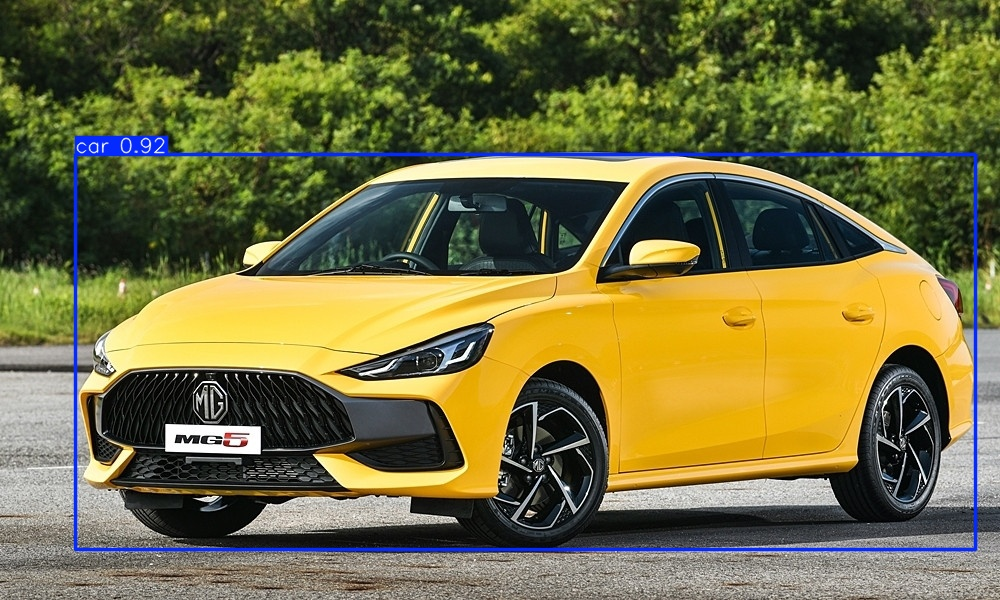

In [ ]:
import os
from IPython.display import Image, display
from ultralytics import YOLO
import glob

from google.colab import files
uploaded = files.upload()
for filename in uploaded.keys():
    input_file = filename
    print(f"File ảnh đầu vào đã tải lên: {input_file}")

MODEL_PATH = '/content/runs/detect/vehicle_training/weights/best.pt'
model = YOLO(MODEL_PATH)

results = model.predict(
    source=input_file,
    conf=0.5,
    show=False,
    save=True, 
    name='predict'
)

print("\nĐã hoàn tất dự đoán. Ảnh kết quả đã được lưu.")

SAVE_DIR = results[0].save_dir

image_file_name = os.path.basename(input_file)
result_image_path = os.path.join(SAVE_DIR, image_file_name)

# Hiển thị hình ảnh
if os.path.exists(result_image_path):
    print(f"\n--- KẾT QUẢ DỰ ĐOÁN ĐƯỢC TÌM THẤY ---")
    print(f"File kết quả được tìm thấy tại: {result_image_path}")
    display(Image(filename=result_image_path))
else:

    print(f"\nĐang tìm kiếm file trong thư mục: {SAVE_DIR}...")

    found_files = glob.glob(os.path.join(SAVE_DIR, '*.jpg'))
    if not found_files:
         found_files = glob.glob(os.path.join(SAVE_DIR, '*.png'))

    if found_files:
        final_result_path = found_files[0]
        print(f"Đã tìm thấy file kết quả dự phòng tại: {final_result_path}")
        display(Image(filename=final_result_path))
    else:
        print("\nLỖI CUỐI CÙNG: Không tìm thấy bất kỳ file ảnh nào trong thư mục kết quả.")
        print(f"Nội dung thư mục {SAVE_DIR} sau khi dự đoán:")
        !ls -l {SAVE_DIR}